# Fundamental Parameter Study

This example is similar to the convection-diffusion example, but testing is the
CFD algorithm is updating correctly, when exposed to new operating conditions.
In this case a fixed temperature is defined on the left boundary (1) and on the
right boundary (0). A prescribed velocity field affects the local temperature
distribution. Several instances of the set-up produce different temperature profiles
across the domain.
In that sense, this example indicates the set-up for a fundamental parameter study.

Moreover, this example validates the correct implementation of the 'central difference' and 'upwind difference' schemes for convective transport.

temperature profile: 
the solid lines correspond to the analytical solution


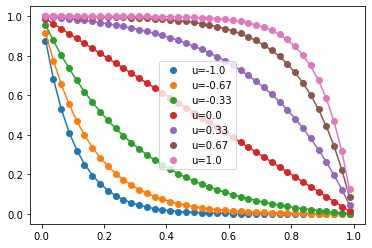

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/MultiphaseTestBench')
import Manager as mptb

import numpy as np

def analyticalHeatProfile(x, gamma,vel, rho, L, T0, TL):
    if vel == 0:
        return T0 + (TL-T0)/L*x
    e = lambda x : np.exp(rho*x*vel/gamma)
    return T0 + (TL-T0)*(e(x)-1)/( e(L) - 1)

# in this test I want to test the update() function of fields. When I change the velocity, the backend matrices must be updated

# geometric parameters
LenX = 1
LenY = 0.2
resolution = 40

# thermal conductivity [ W / (m K) ]
k = 0.1

# density [kg/m^3
rho = 1

# const temperature at left/right boundaries [K]
T_l = 1
T_r = 0

geom = mptb.createGeometry( 'rectangle', [LenX, LenY] )
mesh = mptb.createMesh( geom, res=resolution )

myFlowModels = {
    'T' : mptb.TransportModels.scalarTransport
}

passiveFields = {
    'u' : 'faces_u',
    'v' : 'faces_v'
}

mptb.initialize(myFlowModels, mesh, geom, passiveFields=passiveFields )

T = mptb.getField('T')
mptb.defineBoundaryCondition(field=T, boundaryName='top', type='zeroGradient')
mptb.defineBoundaryCondition(field=T, boundaryName='bottom', type='zeroGradient')
mptb.defineBoundaryCondition(field=T, boundaryName='left', type='fixedValue', value=T_l )
mptb.defineBoundaryCondition(field=T, boundaryName='right', type='fixedValue', value=T_r )

T.govModel.setDiffusionCoefficient(value=k)

print("temperature profile:",
      "\nthe solid lines correspond to the analytical solution")
import matplotlib.pyplot as plt

nbcellsX = mesh.cells_x
cellSpacing = mesh.uniformSpacing
L = geom.lenX
xSim = np.linspace(0+0.5*cellSpacing,LenX-0.5*cellSpacing,nbcellsX)
ax = plt.gca()

u = mptb.getField('u')
for u_value in np.linspace(-1,1,7):
    u.fill(u_value)

    T.data = mptb.solve(T)
    ySim = T.data[0,:]
    p = ax.plot(xSim, ySim, 'o', label="u={u_value:.2}".format(**locals()))
    ax.plot(xSim, analyticalHeatProfile(xSim, k, u_value, rho, LenX, T_l, T_r), '-', color=p[0].get_color())

plt.legend()
plt.show()

In [ ]:
# shutting the interpreter down, so I can a fresh instance next time.
# my modules are automatically checked for updates
import os
os._exit(00)